In [1]:
import warnings
warnings.filterwarnings("ignore")

from astropy.io import fits
from astropy.wcs import WCS
import matplotlib as mpl
import matplotlib.pyplot as plt
from sedcreator import SedFluxer, SedFitter
from astropy.visualization import simple_norm
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5
from astroquery.vizier import Vizier;Vizier.ROW_LIMIT=-1
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
from photutils.aperture import EllipticalAperture
from photutils.aperture import RectangularAperture, ApertureStats, CircularAperture
from astropy.nddata import CCDData
from ccdproc import ImageFileCollection
from astropy.stats import mad_std
import ccdproc as ccdp
from pathlib import Path
import os
from ccdproc import wcs_project
import astroalign as aa
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image
from astropy.modeling import models, fitting
from astroquery.gaia import Gaia
from scipy.integrate import quad
import numpy as np
from scipy import optimize as opt
import copy
from scipy.spatial import distance
import skimage.io
from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm import colorify
from astropy.coordinates import Angle
from photutils.aperture import aperture_photometry
from astropy.visualization.wcsaxes import add_beam, add_scalebar
import math
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib.patches import Rectangle, Circle
from scipy import ndimage
from astroquery.esasky import ESASky
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization import make_lupton_rgb
%matplotlib notebook
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
F115W_PSC = pd.read_csv('PSC/F115W_PSC_CAM.ecsv', sep=" ", skiprows=1, names = ['el','xcentroid','ycentroid','sky_centroid.ra','sky_centroid.dec','aper_bkg_flux','aper_bkg_flux_err','aper30_flux','aper30_flux_err','aper50_flux','aper50_flux_err','aper70_flux','aper70_flux_err','aper_total_flux','aper_total_flux_err','aper30_abmag','aper30_abmag_err','aper50_abmag','aper50_abmag_err','aper70_abmag','aper70_abmag_err','aper_total_abmag','aper_total_abmag_err','aper30_vegamag','aper30_vegamag_err','aper50_vegamag','aper50_vegamag_err','aper70_vegamag','aper70_vegamag_err','aper_total_vegamag','aper_total_vegamag_err','CI_50_30','CI_70_50','CI_70_30','is_extended','sharpness','roundness','nn_label','nn_dist','isophotal_flux','isophotal_flux_err','isophotal_abmag','isophotal_abmag_err','isophotal_vegamag','isophotal_vegamag_err','isophotal_area','semimajor_sigma','semiminor_sigma','ellipticity','orientation','sky_orientation','sky_bbox_ll.ra','sky_bbox_ll.dec','sky_bbox_ul.ra','sky_bbox_ul.dec','sky_bbox_lr.ra','sky_bbox_lr.dec','sky_bbox_ur.ra','sky_bbox_ur.dec'])
F115W_PSC = F115W_PSC[263:]
F115W_PSC.reset_index(inplace=True)
for x in range(len(F115W_PSC)):
    F115W_PSC['sky_centroid.dec'][x] = float(F115W_PSC['sky_centroid.dec'][x])
    F115W_PSC['sky_centroid.ra'][x] = float(F115W_PSC['sky_centroid.ra'][x])
    F115W_PSC['aper_total_vegamag'][x] = float(F115W_PSC['aper_total_vegamag'][x])
    F115W_PSC['aper_total_abmag'][x] = float(F115W_PSC['aper_total_abmag'][x])
    #Turn the necessary values into floats so they can be used

F162M_PSC = pd.read_csv('PSC/F162M_PSC_CAM.ecsv', sep=" ", skiprows=1, names = ['el','xcentroid','ycentroid','sky_centroid.ra','sky_centroid.dec','aper_bkg_flux','aper_bkg_flux_err','aper30_flux','aper30_flux_err','aper50_flux','aper50_flux_err','aper70_flux','aper70_flux_err','aper_total_flux','aper_total_flux_err','aper30_abmag','aper30_abmag_err','aper50_abmag','aper50_abmag_err','aper70_abmag','aper70_abmag_err','aper_total_abmag','aper_total_abmag_err','aper30_vegamag','aper30_vegamag_err','aper50_vegamag','aper50_vegamag_err','aper70_vegamag','aper70_vegamag_err','aper_total_vegamag','aper_total_vegamag_err','CI_50_30','CI_70_50','CI_70_30','is_extended','sharpness','roundness','nn_label','nn_dist','isophotal_flux','isophotal_flux_err','isophotal_abmag','isophotal_abmag_err','isophotal_vegamag','isophotal_vegamag_err','isophotal_area','semimajor_sigma','semiminor_sigma','ellipticity','orientation','sky_orientation','sky_bbox_ll.ra','sky_bbox_ll.dec','sky_bbox_ul.ra','sky_bbox_ul.dec','sky_bbox_lr.ra','sky_bbox_lr.dec','sky_bbox_ur.ra','sky_bbox_ur.dec'])
F162M_PSC = F162M_PSC[263:]
F162M_PSC.reset_index(inplace=True)
for x in range(len(F162M_PSC)):
    F162M_PSC['sky_centroid.dec'][x] = float(F162M_PSC['sky_centroid.dec'][x])
    F162M_PSC['sky_centroid.ra'][x] = float(F162M_PSC['sky_centroid.ra'][x])
    F162M_PSC['aper_total_vegamag'][x] = float(F162M_PSC['aper_total_vegamag'][x])
    F162M_PSC['aper_total_abmag'][x] = float(F162M_PSC['aper_total_abmag'][x])
    
F212N_PSC = pd.read_csv('PSC/F212N_PSC_CAM.ecsv', sep=" ", skiprows=1, names = ['el','xcentroid','ycentroid','sky_centroid.ra','sky_centroid.dec','aper_bkg_flux','aper_bkg_flux_err','aper30_flux','aper30_flux_err','aper50_flux','aper50_flux_err','aper70_flux','aper70_flux_err','aper_total_flux','aper_total_flux_err','aper30_abmag','aper30_abmag_err','aper50_abmag','aper50_abmag_err','aper70_abmag','aper70_abmag_err','aper_total_abmag','aper_total_abmag_err','aper30_vegamag','aper30_vegamag_err','aper50_vegamag','aper50_vegamag_err','aper70_vegamag','aper70_vegamag_err','aper_total_vegamag','aper_total_vegamag_err','CI_50_30','CI_70_50','CI_70_30','is_extended','sharpness','roundness','nn_label','nn_dist','isophotal_flux','isophotal_flux_err','isophotal_abmag','isophotal_abmag_err','isophotal_vegamag','isophotal_vegamag_err','isophotal_area','semimajor_sigma','semiminor_sigma','ellipticity','orientation','sky_orientation','sky_bbox_ll.ra','sky_bbox_ll.dec','sky_bbox_ul.ra','sky_bbox_ul.dec','sky_bbox_lr.ra','sky_bbox_lr.dec','sky_bbox_ur.ra','sky_bbox_ur.dec'])
F212N_PSC = F212N_PSC[263:]
F212N_PSC.reset_index(inplace=True)
for x in range(len(F212N_PSC)):
    F212N_PSC['sky_centroid.dec'][x] = float(F212N_PSC['sky_centroid.dec'][x])
    F212N_PSC['sky_centroid.ra'][x] = float(F212N_PSC['sky_centroid.ra'][x])
    F212N_PSC['aper_total_vegamag'][x] = float(F212N_PSC['aper_total_vegamag'][x])
    F212N_PSC['aper_total_abmag'][x] = float(F212N_PSC['aper_total_abmag'][x])
    
F360M_PSC = pd.read_csv('PSC/F360M_PSC_CAM.ecsv', sep=" ", skiprows=1, names = ['el','xcentroid','ycentroid','sky_centroid.ra','sky_centroid.dec','aper_bkg_flux','aper_bkg_flux_err','aper30_flux','aper30_flux_err','aper50_flux','aper50_flux_err','aper70_flux','aper70_flux_err','aper_total_flux','aper_total_flux_err','aper30_abmag','aper30_abmag_err','aper50_abmag','aper50_abmag_err','aper70_abmag','aper70_abmag_err','aper_total_abmag','aper_total_abmag_err','aper30_vegamag','aper30_vegamag_err','aper50_vegamag','aper50_vegamag_err','aper70_vegamag','aper70_vegamag_err','aper_total_vegamag','aper_total_vegamag_err','CI_50_30','CI_70_50','CI_70_30','is_extended','sharpness','roundness','nn_label','nn_dist','isophotal_flux','isophotal_flux_err','isophotal_abmag','isophotal_abmag_err','isophotal_vegamag','isophotal_vegamag_err','isophotal_area','semimajor_sigma','semiminor_sigma','ellipticity','orientation','sky_orientation','sky_bbox_ll.ra','sky_bbox_ll.dec','sky_bbox_ul.ra','sky_bbox_ul.dec','sky_bbox_lr.ra','sky_bbox_lr.dec','sky_bbox_ur.ra','sky_bbox_ur.dec'])
F360M_PSC = F360M_PSC[263:]
F360M_PSC.reset_index(inplace=True)
for x in range(len(F360M_PSC)):
    F360M_PSC['sky_centroid.dec'][x] = float(F360M_PSC['sky_centroid.dec'][x])
    F360M_PSC['sky_centroid.ra'][x] = float(F360M_PSC['sky_centroid.ra'][x])
    F360M_PSC['aper_total_vegamag'][x] = float(F360M_PSC['aper_total_vegamag'][x])
    F360M_PSC['aper_total_abmag'][x] = float(F360M_PSC['aper_total_abmag'][x])
    
F470N_PSC = pd.read_csv('PSC/F470N_PSC_CAM.ecsv', sep=" ", skiprows=1, names = ['el','xcentroid','ycentroid','sky_centroid.ra','sky_centroid.dec','aper_bkg_flux','aper_bkg_flux_err','aper30_flux','aper30_flux_err','aper50_flux','aper50_flux_err','aper70_flux','aper70_flux_err','aper_total_flux','aper_total_flux_err','aper30_abmag','aper30_abmag_err','aper50_abmag','aper50_abmag_err','aper70_abmag','aper70_abmag_err','aper_total_abmag','aper_total_abmag_err','aper30_vegamag','aper30_vegamag_err','aper50_vegamag','aper50_vegamag_err','aper70_vegamag','aper70_vegamag_err','aper_total_vegamag','aper_total_vegamag_err','CI_50_30','CI_70_50','CI_70_30','is_extended','sharpness','roundness','nn_label','nn_dist','isophotal_flux','isophotal_flux_err','isophotal_abmag','isophotal_abmag_err','isophotal_vegamag','isophotal_vegamag_err','isophotal_area','semimajor_sigma','semiminor_sigma','ellipticity','orientation','sky_orientation','sky_bbox_ll.ra','sky_bbox_ll.dec','sky_bbox_ul.ra','sky_bbox_ul.dec','sky_bbox_lr.ra','sky_bbox_lr.dec','sky_bbox_ur.ra','sky_bbox_ur.dec'])
F470N_PSC = F470N_PSC[263:]
F470N_PSC.reset_index(inplace=True)
for x in range(len(F470N_PSC)):
    F470N_PSC['sky_centroid.dec'][x] = float(F470N_PSC['sky_centroid.dec'][x])
    F470N_PSC['sky_centroid.ra'][x] = float(F470N_PSC['sky_centroid.ra'][x])
    F470N_PSC['aper_total_vegamag'][x] = float(F470N_PSC['aper_total_vegamag'][x])
    F470N_PSC['aper_total_abmag'][x] = float(F470N_PSC['aper_total_abmag'][x])
    
F480M_PSC = pd.read_csv('PSC/F480M_PSC_CAM.ecsv', sep=" ", skiprows=1, names = ['el','xcentroid','ycentroid','sky_centroid.ra','sky_centroid.dec','aper_bkg_flux','aper_bkg_flux_err','aper30_flux','aper30_flux_err','aper50_flux','aper50_flux_err','aper70_flux','aper70_flux_err','aper_total_flux','aper_total_flux_err','aper30_abmag','aper30_abmag_err','aper50_abmag','aper50_abmag_err','aper70_abmag','aper70_abmag_err','aper_total_abmag','aper_total_abmag_err','aper30_vegamag','aper30_vegamag_err','aper50_vegamag','aper50_vegamag_err','aper70_vegamag','aper70_vegamag_err','aper_total_vegamag','aper_total_vegamag_err','CI_50_30','CI_70_50','CI_70_30','is_extended','sharpness','roundness','nn_label','nn_dist','isophotal_flux','isophotal_flux_err','isophotal_abmag','isophotal_abmag_err','isophotal_vegamag','isophotal_vegamag_err','isophotal_area','semimajor_sigma','semiminor_sigma','ellipticity','orientation','sky_orientation','sky_bbox_ll.ra','sky_bbox_ll.dec','sky_bbox_ul.ra','sky_bbox_ul.dec','sky_bbox_lr.ra','sky_bbox_lr.dec','sky_bbox_ur.ra','sky_bbox_ur.dec'])
F480M_PSC = F480M_PSC[263:]
F480M_PSC.reset_index(inplace=True)
for x in range(len(F480M_PSC)):
    F480M_PSC['sky_centroid.dec'][x] = float(F480M_PSC['sky_centroid.dec'][x])
    F480M_PSC['sky_centroid.ra'][x] = float(F480M_PSC['sky_centroid.ra'][x])
    F480M_PSC['aper_total_vegamag'][x] = float(F480M_PSC['aper_total_vegamag'][x])
    F480M_PSC['aper_total_abmag'][x] = float(F480M_PSC['aper_total_abmag'][x])
    
F115W_coords = SkyCoord(ra=F115W_PSC['sky_centroid.ra'],dec=F115W_PSC['sky_centroid.dec'],unit=u.deg,frame='fk5')
F162M_coords = SkyCoord(ra=F162M_PSC['sky_centroid.ra'],dec=F162M_PSC['sky_centroid.dec'],unit=u.deg,frame='fk5')
F212N_coords = SkyCoord(ra=F212N_PSC['sky_centroid.ra'],dec=F212N_PSC['sky_centroid.dec'],unit=u.deg,frame='fk5')
F360M_coords = SkyCoord(ra=F360M_PSC['sky_centroid.ra'],dec=F360M_PSC['sky_centroid.dec'],unit=u.deg,frame='fk5')
F470N_coords = SkyCoord(ra=F470N_PSC['sky_centroid.ra'],dec=F470N_PSC['sky_centroid.dec'],unit=u.deg,frame='fk5')
F480M_coords = SkyCoord(ra=F480M_PSC['sky_centroid.ra'],dec=F480M_PSC['sky_centroid.dec'],unit=u.deg,frame='fk5')

In [5]:
np.min(F480M_PSC['aper_total_vegamag'])

12.138206567028929

<IPython.core.display.Javascript object>


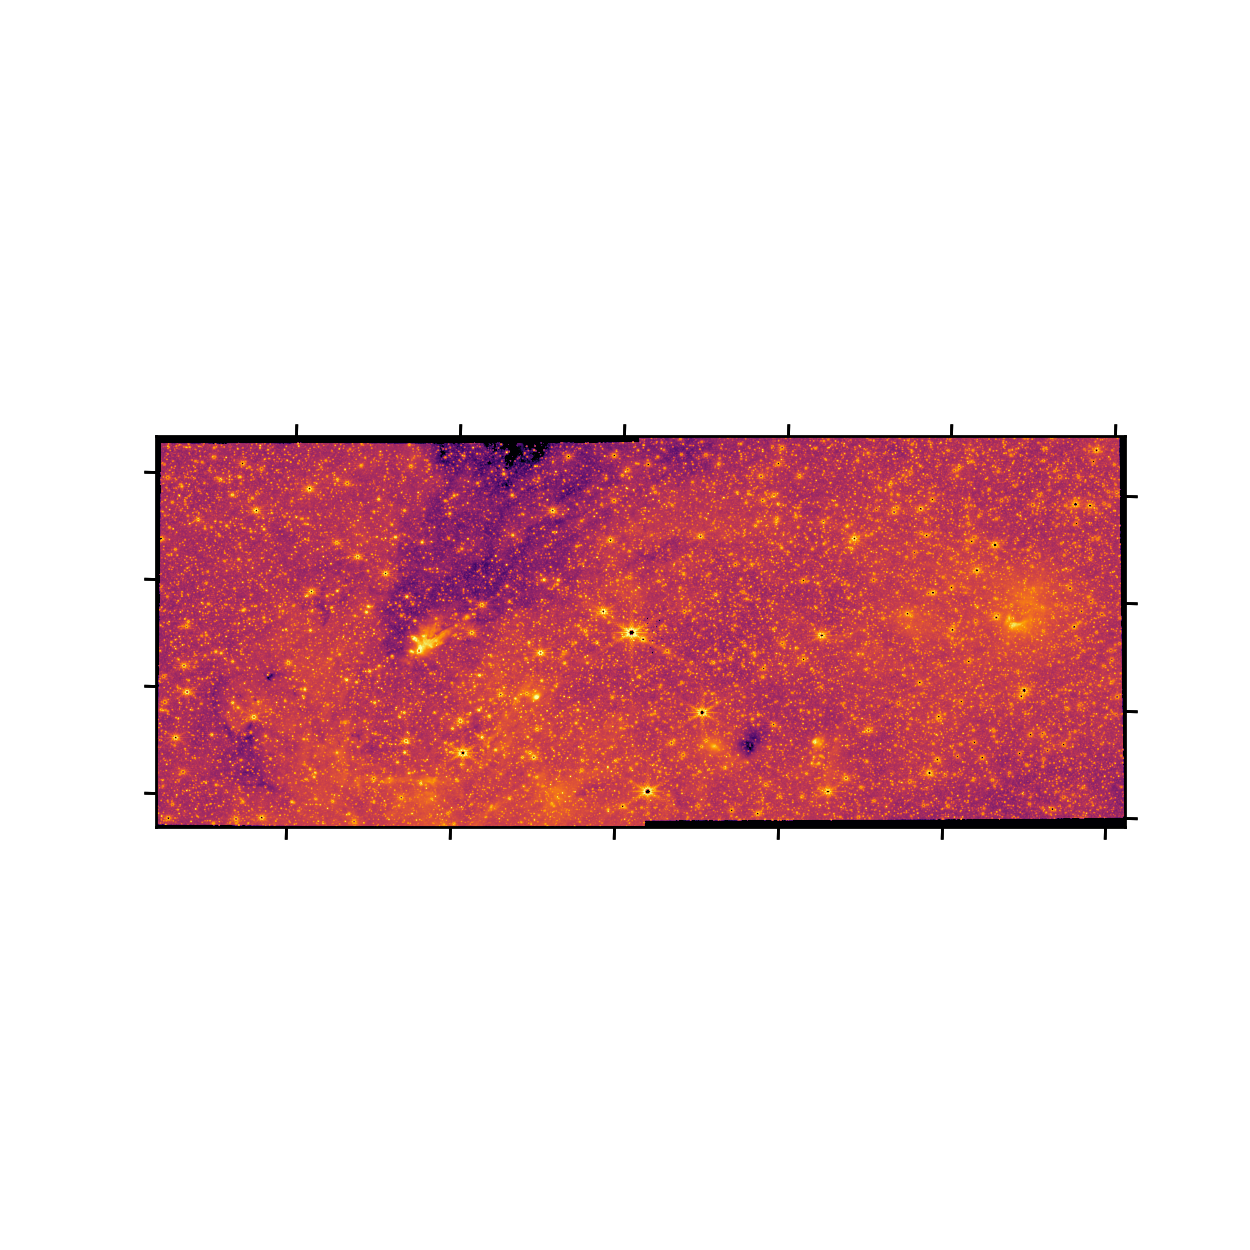

NameError: name 'F480M_PSC' is not defined

In [51]:
# F480M = fits.open('NIRCAM/F480M_CAM.fits')[1]
        
# wcs = WCS(F480M.header)
# plt.figure(figsize=(5,5))
       
# ax = plt.subplot(projection=wcs)
# norm = simple_norm(F480M.data[F480M.data>0], stretch='log', percent=99.7)
# ax.imshow(F480M.data, origin='lower', cmap='inferno', norm=norm)
# for x in range(len(F480M_PSC)):
#     ax.scatter(F480M_PSC['sky_centroid.ra'][x], F480M_PSC['sky_centroid.dec'][x], s=5, facecolor='cyan',zorder=1,transform=ax.get_transform('fk5'))

In [28]:
c = SkyCoord(ra=F212N_PSC['sky_centroid.ra'][0], dec=F212N_PSC['sky_centroid.dec'][0],unit=u.deg,frame='fk5')
idx, d2d, d3d = F212N_coords.match_to_catalog_sky(F360M_coords)

<IPython.core.display.Javascript object>


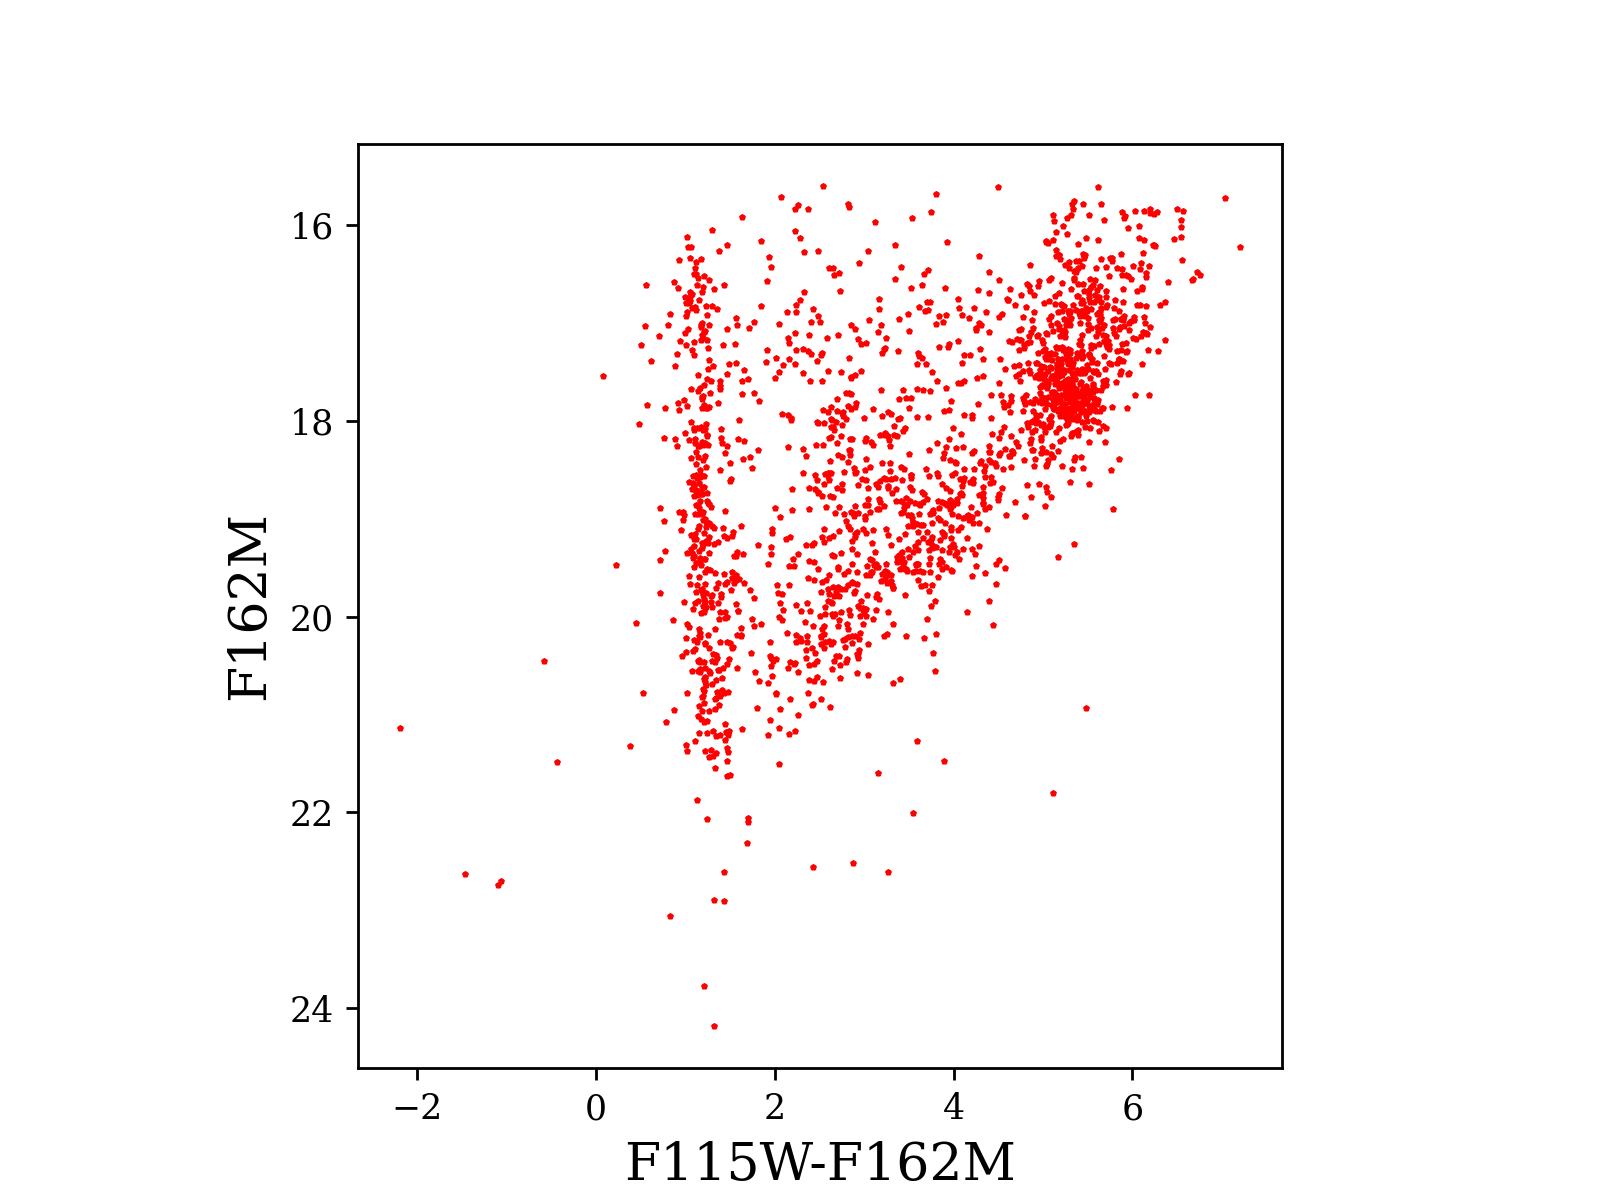

In [3]:
#F115W-F162M vs F162M

idx, d2d, d3d = F115W_coords.match_to_catalog_sky(F162M_coords) #Crossmatch the coordinate lists
F115W_F162M_mag = []
F162M_mag = []

for x in range(len(F115W_PSC)):
    if float(d2d[x].to(u.arcsec)/u.arcsec)<0.1: #Impose a minimum separation for corresponding sources to be considered
        F162M_mag.append(F162M_PSC['aper_total_vegamag'][idx[x]])
        F115W_F162M_mag.append(F115W_PSC['aper_total_vegamag'][x]-F162M_PSC['aper_total_vegamag'][idx[x]])
        
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(x=F115W_F162M_mag, y=F162M_mag, marker = '*', s=1, color='red', zorder=5)

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('F115W-F162M', fontsize='15')
ax.set_ylabel('F162M', fontsize='15')
plt.gca().invert_yaxis()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

<IPython.core.display.Javascript object>


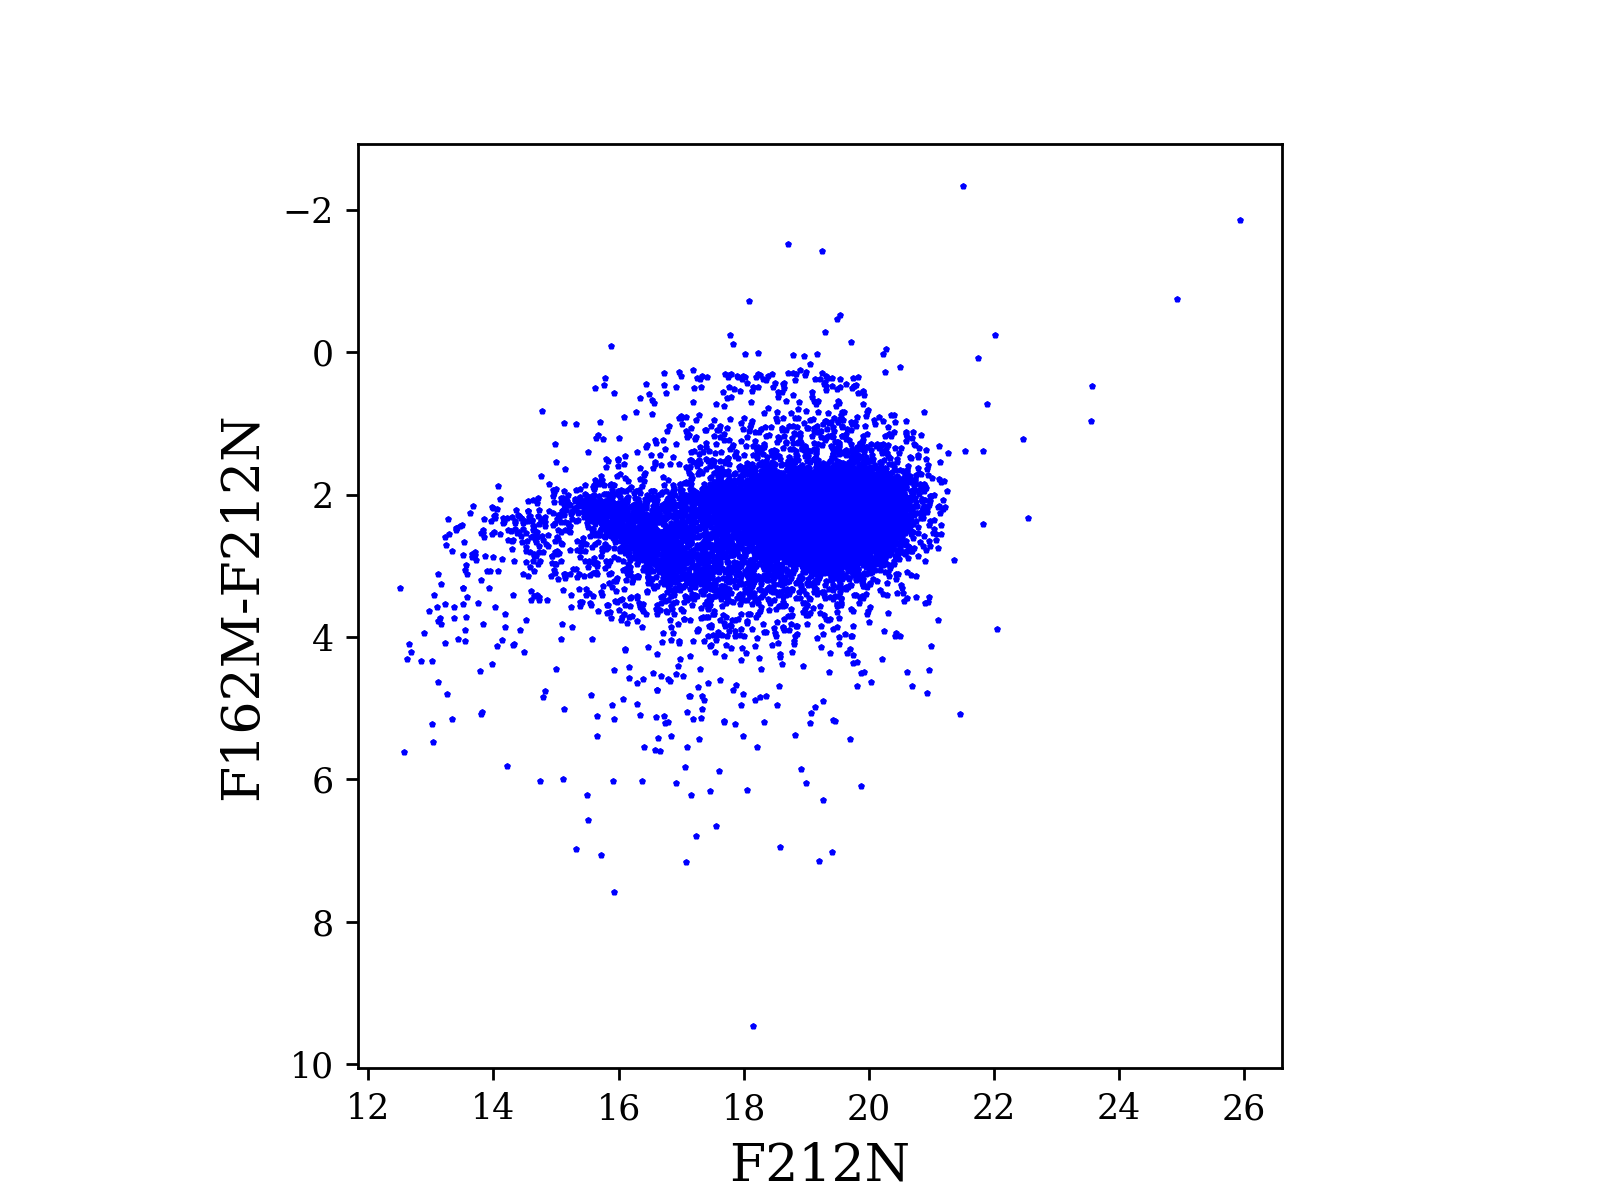

In [7]:
#F162M-F212N vs F212N

idx, d2d, d3d = F162M_coords.match_to_catalog_sky(F212N_coords)
F162M_F212N_mag = []
F212N_mag = []

for x in range(len(F162M_PSC)):
    if float(d2d[x].to(u.arcsec)/u.arcsec)<0.1:
        F212N_mag.append(F212N_PSC['aper_total_vegamag'][idx[x]])
        F162M_F212N_mag.append(F162M_PSC['aper_total_vegamag'][x]-F212N_PSC['aper_total_vegamag'][idx[x]])
        
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(x=F212N_mag, y=F162M_F212N_mag, marker = '*', s=1, color='blue', zorder=5)

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('F212N', fontsize='15')
ax.set_ylabel('F162M-F212N', fontsize='15')
plt.gca().invert_yaxis()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

<IPython.core.display.Javascript object>


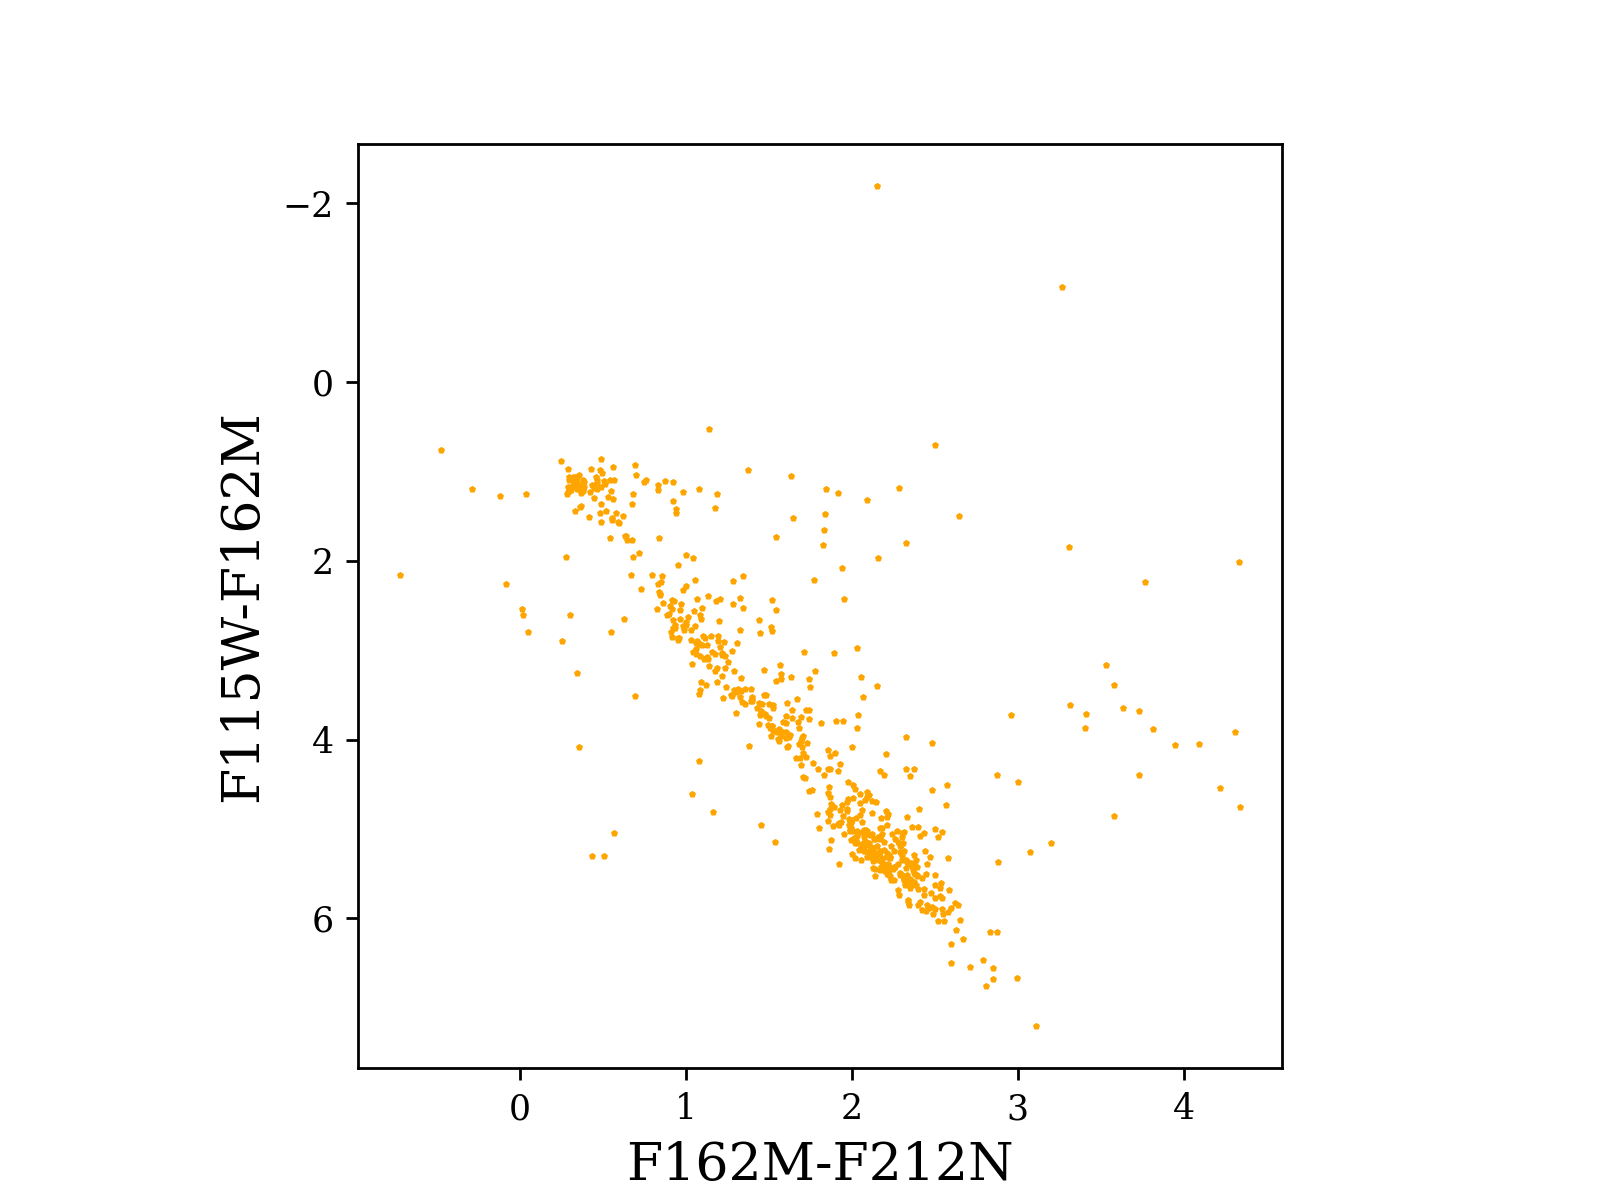

In [8]:
#F115W-F162M vs F162M-F212N

idx_1, d2d_1, d3d = F162M_coords.match_to_catalog_sky(F115W_coords)
idx_2, d2d_2, d3d = F162M_coords.match_to_catalog_sky(F212N_coords)
F115W_F162M_mag = []
F162M_F212N_mag = []

for x in range(len(F162M_PSC)):
    if float(d2d_1[x].to(u.arcsec)/u.arcsec)<0.1 and float(d2d_2[x].to(u.arcsec)/u.arcsec)<0.1:
        F115W_F162M_mag.append(F115W_PSC['aper_total_vegamag'][idx_1[x]]-F162M_PSC['aper_total_vegamag'][x])
        F162M_F212N_mag.append(F162M_PSC['aper_total_vegamag'][x]-F212N_PSC['aper_total_vegamag'][idx_2[x]])    
        
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(x=F162M_F212N_mag, y=F115W_F162M_mag, marker = '*', s=1, color='orange', zorder=5)

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('F162M-F212N', fontsize='15')
ax.set_ylabel('F115W-F162M', fontsize='15')
plt.gca().invert_yaxis()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

<IPython.core.display.Javascript object>


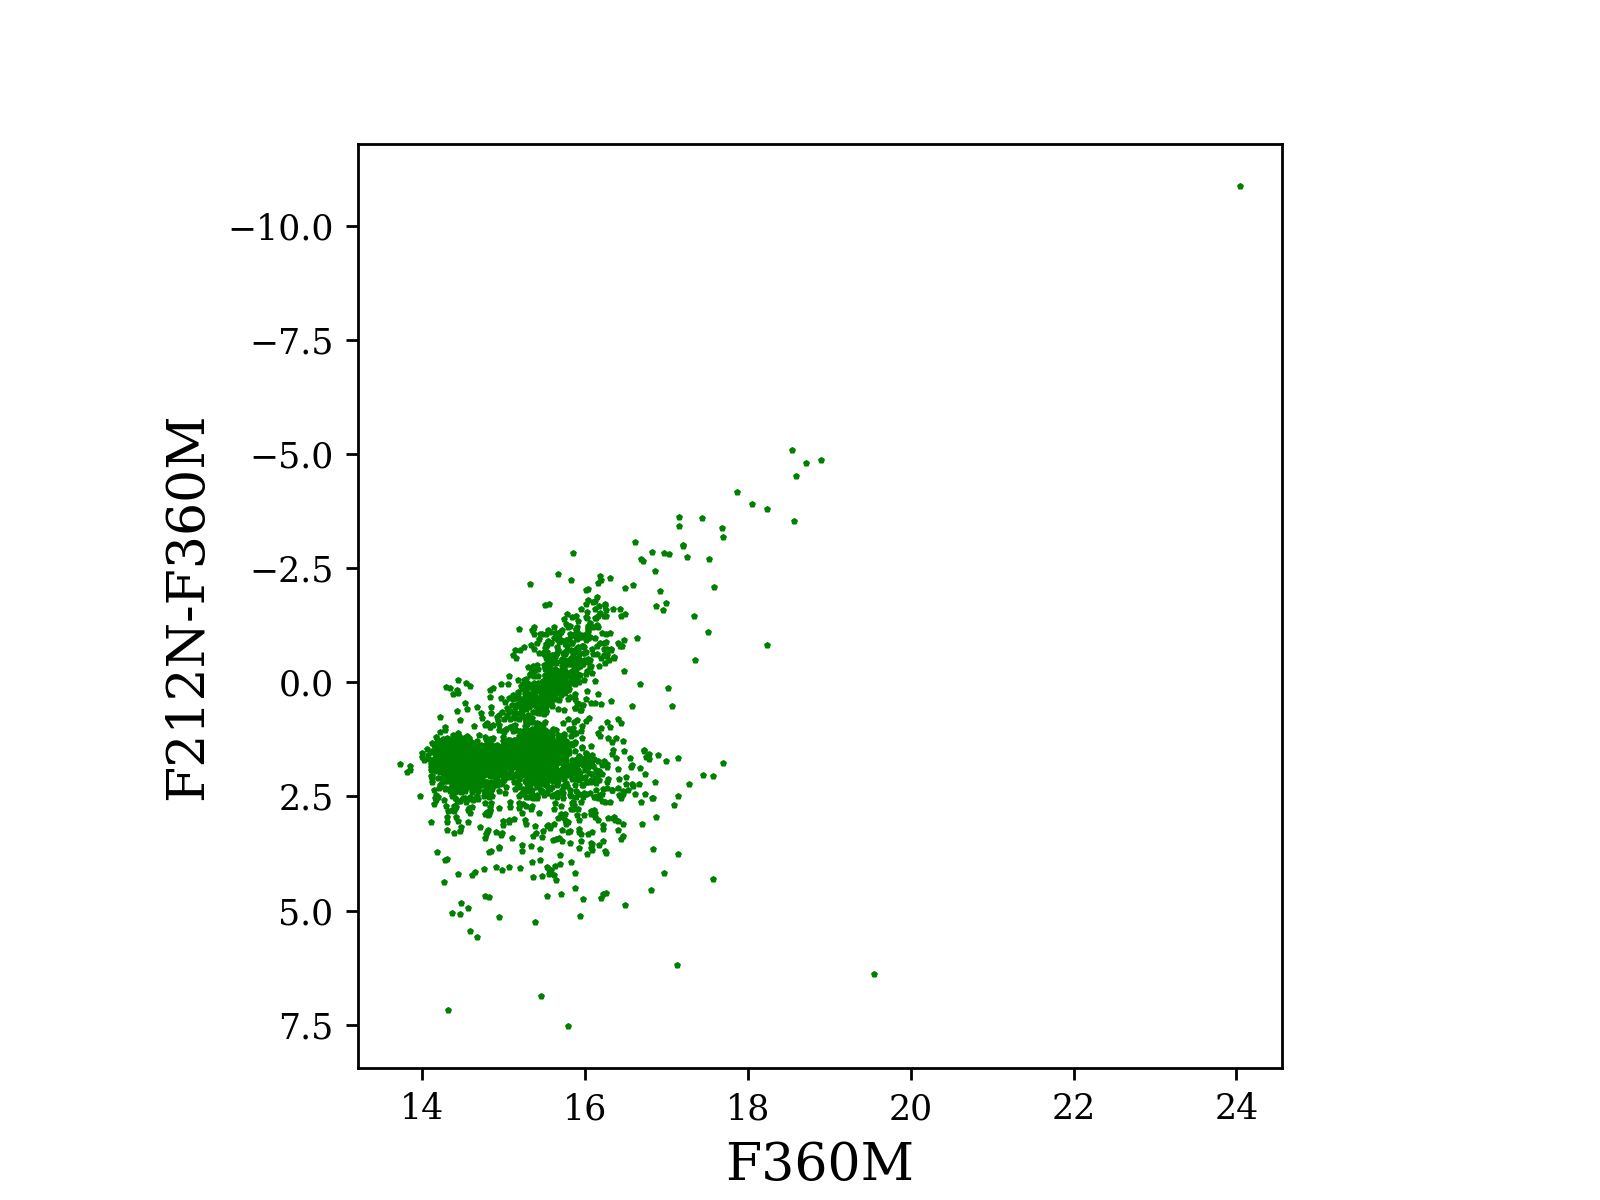

In [9]:
#F212N-F360M vs F360M

idx, d2d, d3d = F212N_coords.match_to_catalog_sky(F360M_coords)
F212N_F360M_mag = []
F360M_mag = []

for x in range(len(F212N_PSC)):
    if float(d2d[x].to(u.arcsec)/u.arcsec)<0.1:
        F360M_mag.append(F360M_PSC['aper_total_vegamag'][idx[x]])
        F212N_F360M_mag.append(F212N_PSC['aper_total_vegamag'][x]-F360M_PSC['aper_total_vegamag'][idx[x]])
        
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(x=F360M_mag, y=F212N_F360M_mag, marker = '*', s=1, color='green', zorder=5)

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('F360M', fontsize='15')
ax.set_ylabel('F212N-F360M', fontsize='15')
plt.gca().invert_yaxis()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

<IPython.core.display.Javascript object>


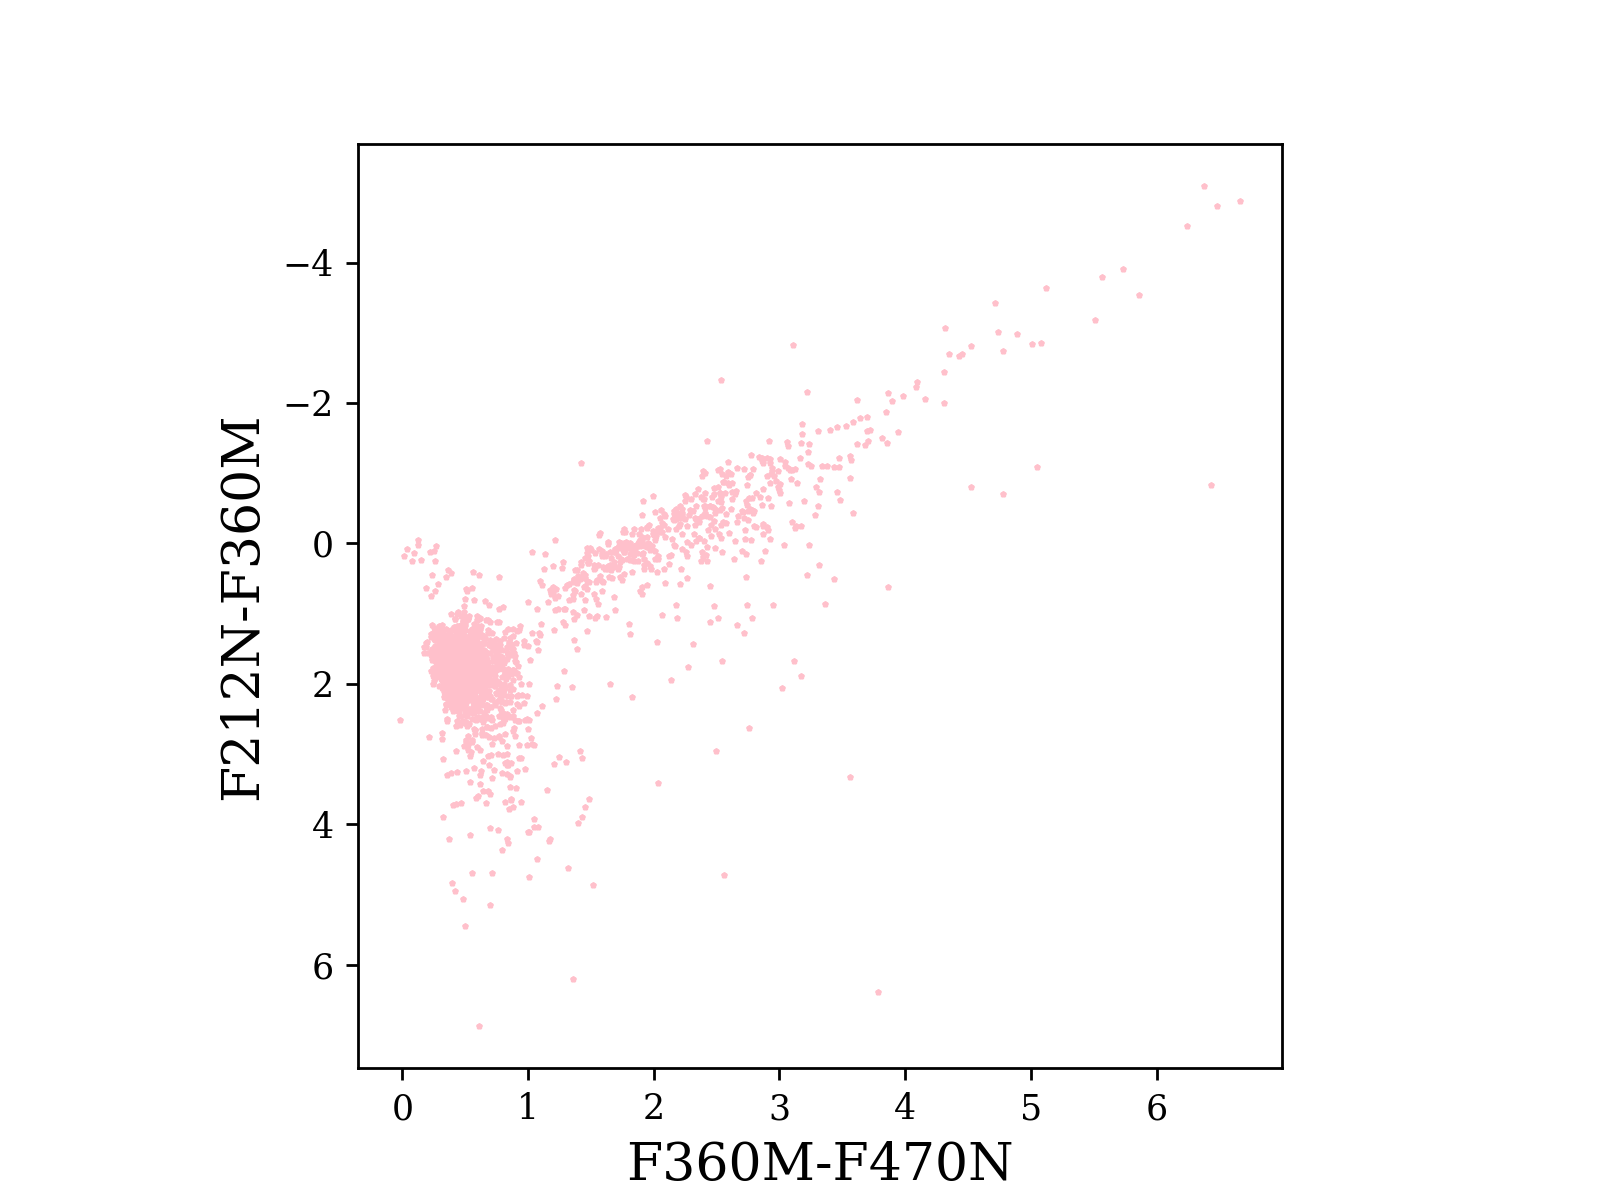

In [11]:
#F212N-F360M vs F360M-F470N

idx_1, d2d_1, d3d = F360M_coords.match_to_catalog_sky(F212N_coords)
idx_2, d2d_2, d3d = F360M_coords.match_to_catalog_sky(F470N_coords)
F212N_F360M_mag = []
F360M_F470N_mag = []

for x in range(len(F360M_PSC)):
    if float(d2d_1[x].to(u.arcsec)/u.arcsec)<0.1 and float(d2d_2[x].to(u.arcsec)/u.arcsec)<0.1:
        F212N_F360M_mag.append(F212N_PSC['aper_total_vegamag'][idx_1[x]]-F360M_PSC['aper_total_vegamag'][x])
        F360M_F470N_mag.append(F360M_PSC['aper_total_vegamag'][x]-F470N_PSC['aper_total_vegamag'][idx_2[x]])    
        
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(x=F360M_F470N_mag, y=F212N_F360M_mag, marker = '*', s=1, color='pink', zorder=5)

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('F360M-F470N', fontsize='15')
ax.set_ylabel('F212N-F360M', fontsize='15')
plt.gca().invert_yaxis()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

<IPython.core.display.Javascript object>


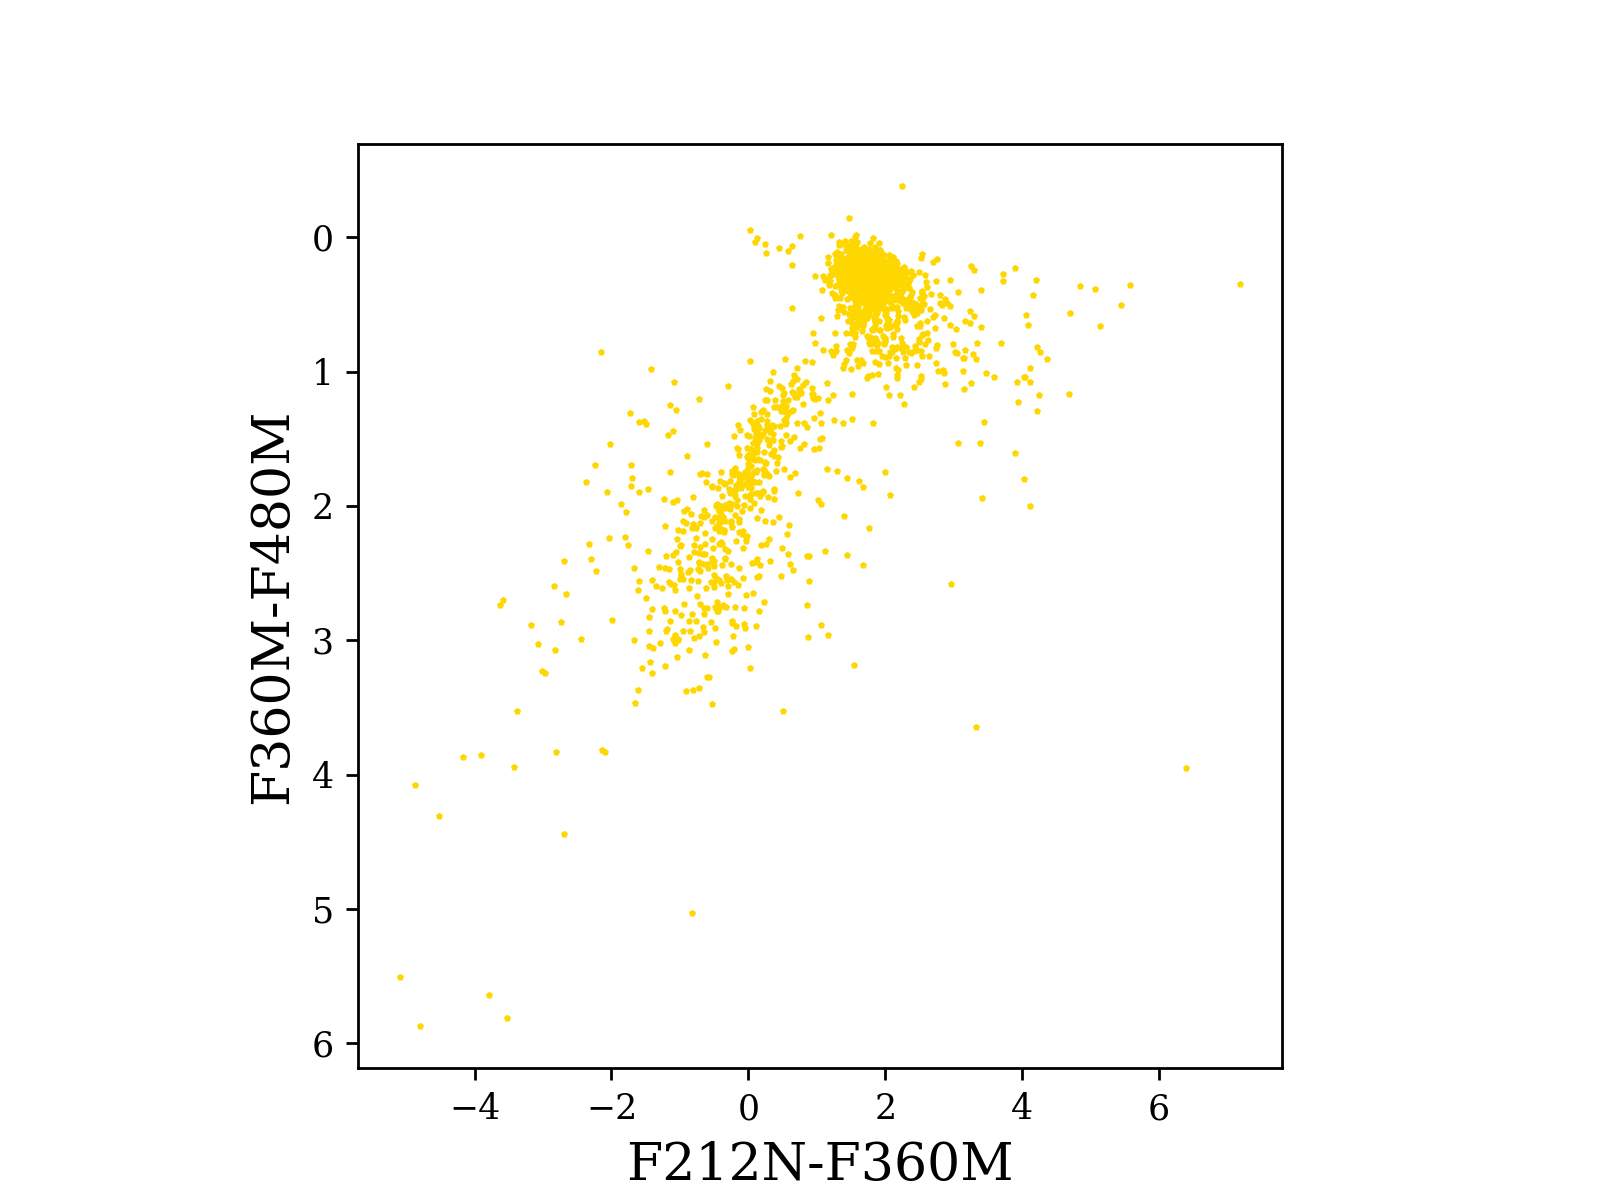

In [12]:
#F212N-F360M vs F360M-F480M

idx_1, d2d_1, d3d = F360M_coords.match_to_catalog_sky(F212N_coords)
idx_2, d2d_2, d3d = F360M_coords.match_to_catalog_sky(F480M_coords)
F212N_F360M_mag = []
F360M_F480M_mag = []

for x in range(len(F360M_PSC)):
    if float(d2d_1[x].to(u.arcsec)/u.arcsec)<0.1 and float(d2d_2[x].to(u.arcsec)/u.arcsec)<0.1:
        F212N_F360M_mag.append(F212N_PSC['aper_total_vegamag'][idx_1[x]]-F360M_PSC['aper_total_vegamag'][x])
        F360M_F480M_mag.append(F360M_PSC['aper_total_vegamag'][x]-F480M_PSC['aper_total_vegamag'][idx_2[x]])    
        
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(x=F212N_F360M_mag, y=F360M_F480M_mag, marker = '*', s=1, color='gold', zorder=5)

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('F212N-F360M', fontsize='15')
ax.set_ylabel('F360M-F480M', fontsize='15')
plt.gca().invert_yaxis()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

<IPython.core.display.Javascript object>


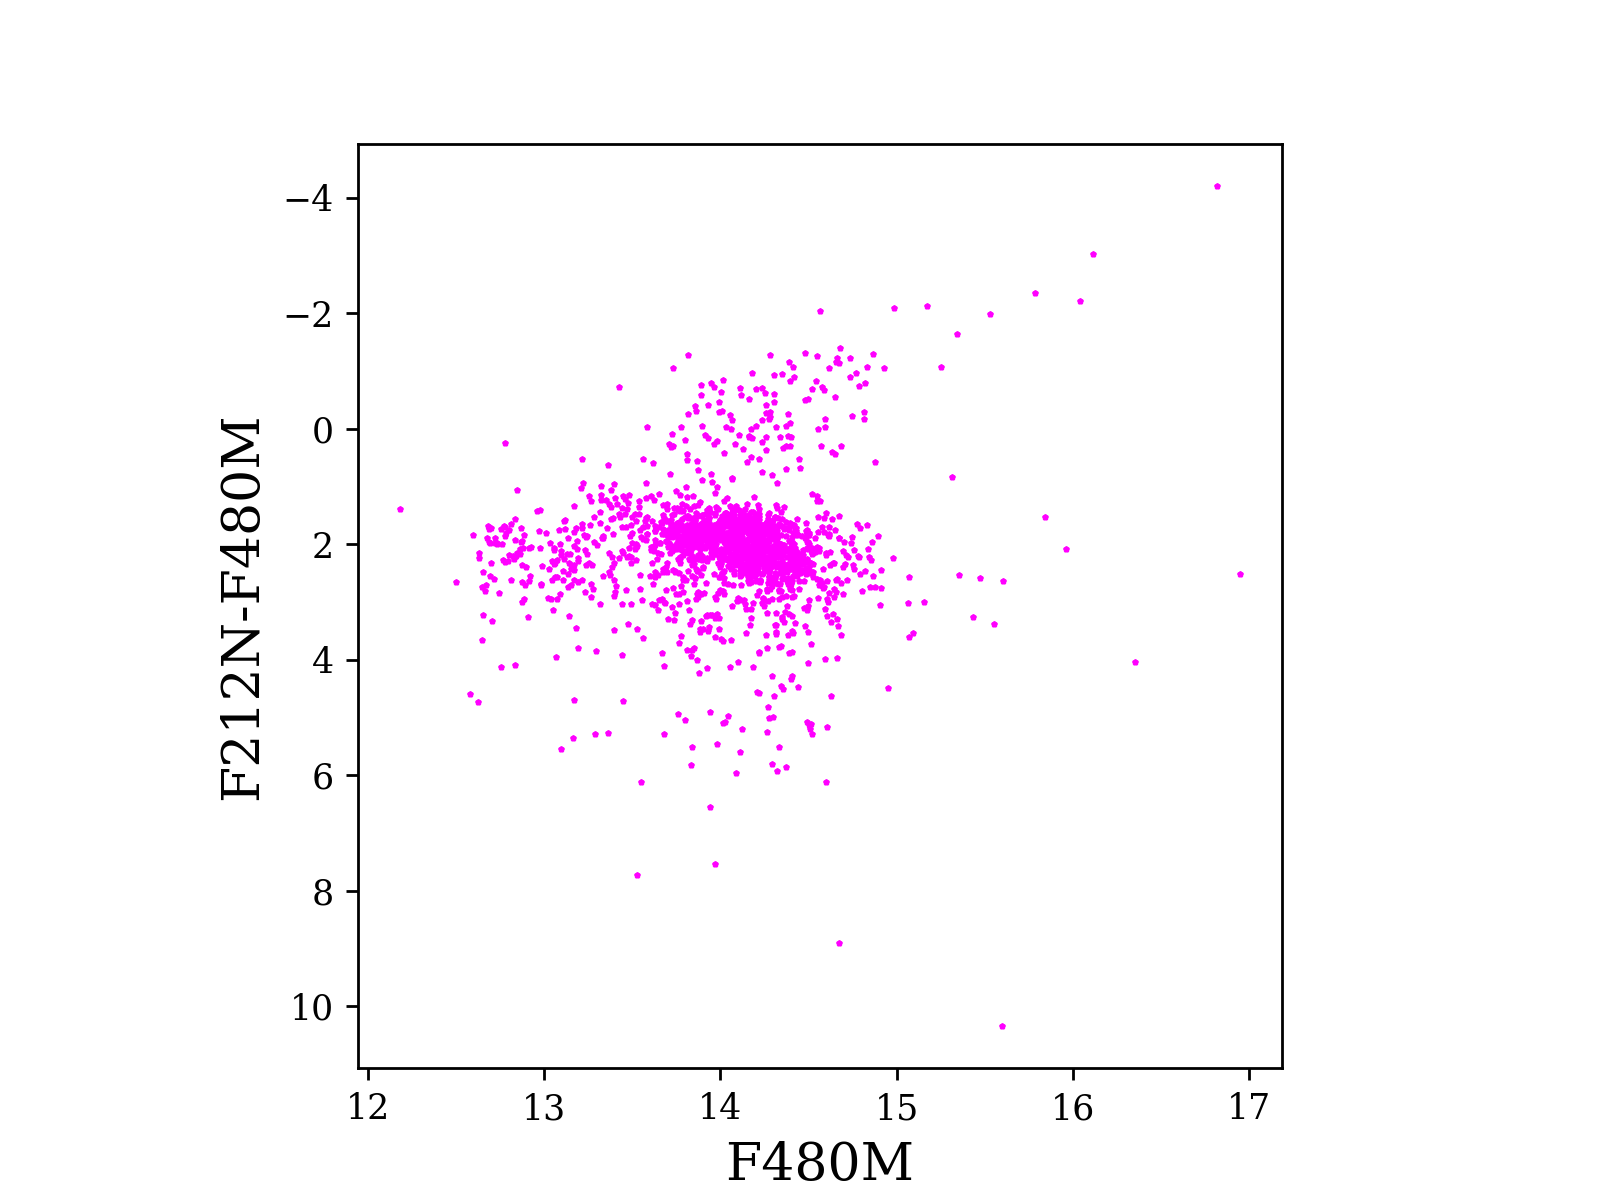

In [14]:
#F212N-F480M vs F480M

idx, d2d, d3d = F212N_coords.match_to_catalog_sky(F480M_coords)
F212N_F480M_mag = []
F480M_mag = []

for x in range(len(F212N_PSC)):
    if float(d2d[x].to(u.arcsec)/u.arcsec)<0.1:
        F480M_mag.append(F480M_PSC['aper_total_vegamag'][idx[x]])
        F212N_F480M_mag.append(F212N_PSC['aper_total_vegamag'][x]-F480M_PSC['aper_total_vegamag'][idx[x]])
        
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(x=F480M_mag, y=F212N_F480M_mag, marker = '*', s=1, color='magenta', zorder=5)

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('F480M', fontsize='15')
ax.set_ylabel('F212N-F480M', fontsize='15')
plt.gca().invert_yaxis()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

<IPython.core.display.Javascript object>


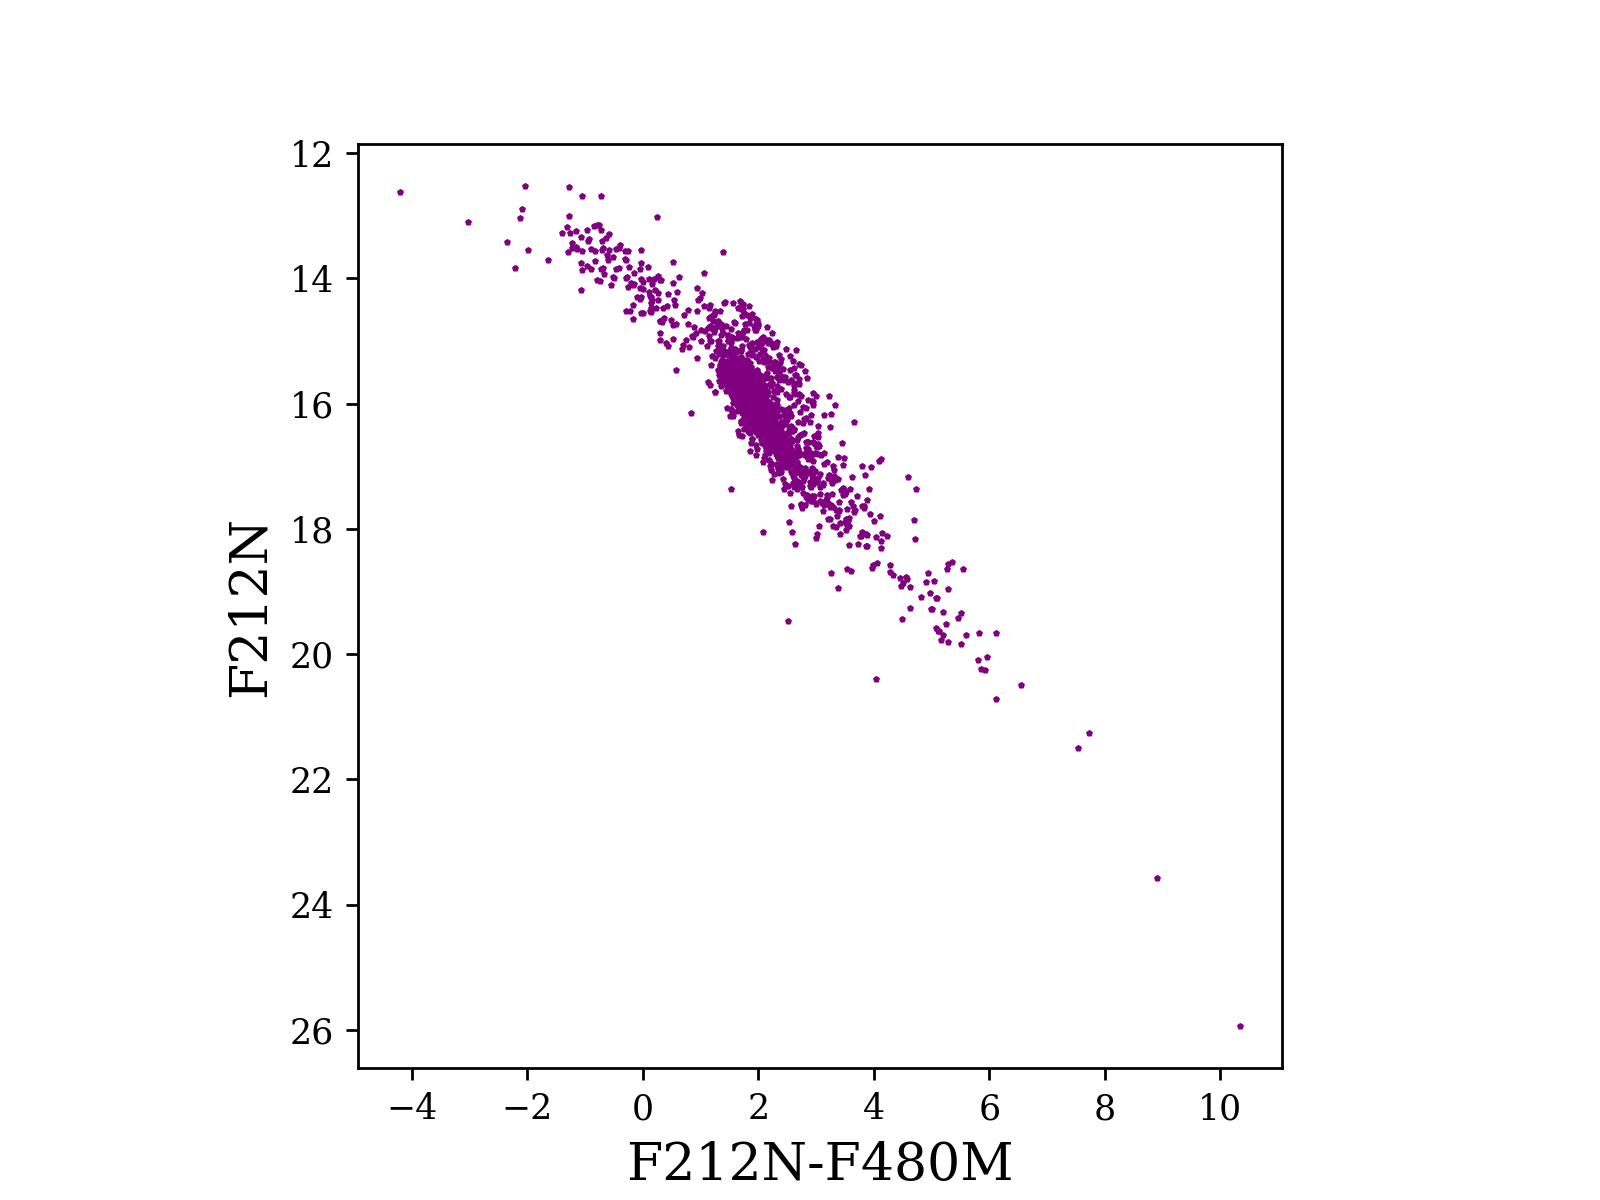

In [16]:
#F212N vs F212N-F480M

idx, d2d, d3d = F212N_coords.match_to_catalog_sky(F480M_coords)
F212N_F480M_mag = []
F212N_mag = []

for x in range(len(F212N_PSC)):
    if float(d2d[x].to(u.arcsec)/u.arcsec)<0.1:
        F212N_mag.append(F212N_PSC['aper_total_vegamag'][x])
        F212N_F480M_mag.append(F212N_PSC['aper_total_vegamag'][x]-F480M_PSC['aper_total_vegamag'][idx[x]])
        
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(x=F212N_F480M_mag, y=F212N_mag, marker = '*', s=1, color='purple', zorder=5)

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('F212N-F480M', fontsize='15')
ax.set_ylabel('F212N', fontsize='15')
plt.gca().invert_yaxis()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')